# Big Traces

This notebook is more optimized for handling large traces and focuses on easy to compute plots and metrics.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pathlib
import matplotlib
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
import statistics
from sortedcontainers import SortedList, SortedDict
import time
from scipy import stats
import pprint
from functools import total_ordering

In [4]:
DATA_DIR = 'parrot-traces/medium-100ms/'

In [67]:
FILES    = [p.absolute() for p in pathlib.Path(DATA_DIR).iterdir()]

@total_ordering
class trace:
    def __init__(self, path):
        self.path = path
        self.name = path.stem.split('_')[2]
        self.data = None
    def _load(self):
        return pd.read_csv(self.path, delim_whitespace=True)
    def load(self, persist=False):
        if self.data is not None:
            return self.data
        if persist:
            self.data = self._load()
            return self.data
        return self._load()
    def unload(self):
        self.data = None
    def loadLat(self):
        return np.array(pd.read_csv(self.path, delim_whitespace=True)['latency_nano'])
    def __repr__(self):
        return self.name
    def __lt__(self, obj):
        return ((self.name) < (obj.name))
    def __eq__(self, obj):
        return (self.name == obj.name)
    
TRACES  = sorted([trace(f) for f in FILES])

def loadAll():
    [t.load(persist=True) for t in TRACES]
    
def unloadAll():
    [t.unload() for t in TRACES]

In [52]:
print('Directory:'.ljust(10), DATA_DIR)
print('Files:'.ljust(10), *TRACES)

Directory: parrot-traces/medium-100ms/
Files:     2mm 3mm adi atax bicg cholesky correlation covariance deriche doitgen durbin fdtd-2d floyd-warshall gemm gemver gesummv gramschmidt heat-3d jacobi-1d jacobi-2d lu ludcmp mvt nussinov seidel-2d symm syr2k syrk trisolv trmm


In [7]:
a = TRACES[3].loadLat()

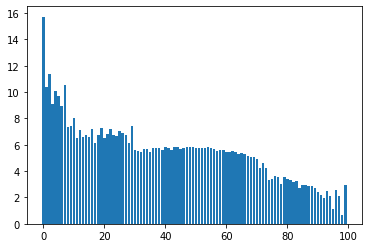

In [8]:
his,_ = np.histogram(a,bins=100)
np.seterr(divide = 'ignore')
fig, ax = plt.subplots()
#ax.hist(a[a>4], bins=100)
ax.bar([*range(len(his))],np.log(his))
plt.show()

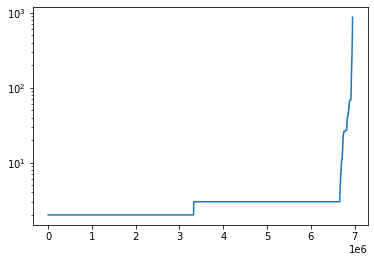

In [9]:
fig, ax = plt.subplots()
ax.semilogy(sorted(a))

In [10]:
#ss = len(str(len(a)))+2
#print(*[label.ljust(ss) for label in ['len', '<3']])
#print(*[str(datapoint).ljust(ss) for datapoint in [len(a), len(a[a<3]), len(a[a<3])/len(a)*100]])

print(f'Length: {len(a)}')
print(f'% < 3 : {len(a[a<3])/len(a):.2f}')
print(f'% < 4 : {len(a[a<4])/len(a):.2f}')
print(f'% < 5 : {len(a[a<5])/len(a):.2f}')

print(f'% < 6 : {len(a[a<6])/len(a):.2f}')
print(f'% < 7 : {len(a[a<7])/len(a):.2f}')
print(f'% < 8 : {len(a[a<8])/len(a):.2f}')


Length: 6954481
% < 3 : 0.48
% < 4 : 0.96
% < 5 : 0.96
% < 6 : 0.96
% < 7 : 0.96
% < 8 : 0.96


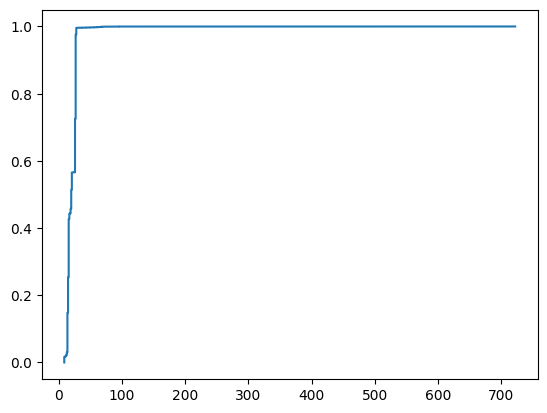

In [124]:
fig, ax = plt.subplots()
ecdf = ECDF(a[a>8])
ax.plot(ecdf.x, ecdf.y)
plt.show()

In [125]:
np.mean(a)

3.620457017787275

In [126]:
np.mean(np.random.choice(a, 1000000))

3.61458

In [132]:
tr = TRACES[0:2]

for t in tr:
    print(max(t.load()['phase']))

1
1


In [131]:
TRACES[0].load().columns

Index(['phase', 'rwf', 'threadID', 'addr', 'latency_nano'], dtype='object')

Overall: 4.89
Per-interval


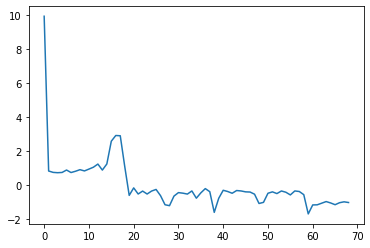

In [11]:
ov = np.mean(a)
print(f'Overall: {ov:.2f}')
print(f'Per-interval')

intlen = 100000
intervals = len(a)//intlen
peri = [np.mean(a[i*intlen : (i+1)*intlen]) for i in range(intervals)]
#print(peri)

fig, ax = plt.subplots()
#ax.plot(peri)
#ax.hlines(y=ov, xmin=0, xmax=intervals, linewidth=2, color='r')

# Error plot
ax.plot(peri-ov)

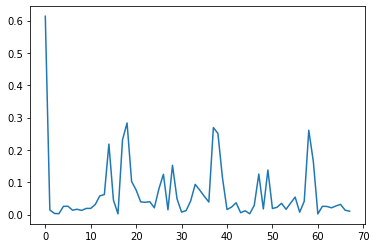

In [15]:
def abspctchange(old, new):
    return np.abs((old - new) / old)
pc = [abspctchange(peri[i], peri[i+1]) for i in range(len(peri)-1)]
#print(np.array(pc) < 0.05)
plt.plot(pc) 
plt.show()

1.0

In [174]:
print(TRACES[3])

durbin


In [100]:
def get_phase_changes(phases):
    pc = []
    for i in range(len(phases)-1):
        if phases[i] != phases[i+1]:
            pc.append(i)
    return pc

def pl_latency_over_time(ax, t, interval_len):
    #ov = np.mean(series)
    #print(f'loading {t.name}')
    df = t.load(persist=True)
    series = df['latency_nano']
    #print('doing get_phase_changes')
    #pc = get_phase_changes(df['phase'])
    #print(pc)
    #print(np.array(pc) // interval_len)
    nintervals = len(series)//interval_len
    peri = [np.mean(series[i*interval_len : (i+1)*interval_len]) for i in range(nintervals)]
    ax.plot(peri)
    ax.xticks([nintervals//2, nintervals])
    

#fig, axs = plt.subplots(ncols=len(TRACES), sharey=True)
#for i, t in enumerate(TRACES[:1]):
#    pl_latency_over_time(axs[i], t, 100000)

#fig.set_size_inches((2*len(TRACES), 2))
#plt.show()

In [200]:
for t in TRACES:
    print(f'{t.name} {max(t.load()["phase"])}')
    


atax 1
bicg 1
deriche 0
durbin 0
gemver 0
gesummv 1
jacobi-1d 0
mvt 0
trisolv 1


In [93]:
class Mapper:
    def __init__(self, size):
        self.size = size
        self.smallest_sq = int(np.ceil(np.sqrt(self.size)))
        
        # There will never be a non-full first row
        self.ncols = self.smallest_sq
        
        # If the last row would be completely empty, reduce this number
        # Only need enough rows to fit up to size elements
        self.nrows = int(np.ceil(self.size / self.ncols))
        
        self.fig, self.ax = plt.subplots(nrows = self.nrows, ncols=self.ncols, sharey=True)

    def get_remainder(self):
        # Any spots that wouldn't be full go here
        return [self[i] for i in range(self.size, size.nrows*self.ncols)]
    
    def __getitem__(self, idx):
        if idx >= self.size:
            raise IndexError(f'Requested index ({idx}) outside configured range (0-{self.size-1}).')
        return self.ax[(idx//self.smallest_sq, idx % self.smallest_sq)]

In [68]:
%%time
loadAll()

CPU times: user 3min 55s, sys: 34.9 s, total: 4min 30s
Wall time: 4min 37s


AttributeError: 'AxesSubplot' object has no attribute 'xticks'

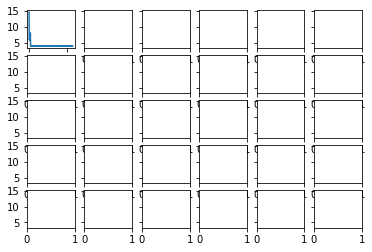

In [101]:
%%time
mapper = Mapper(len(TRACES))
fig = mapper.fig
#fig, axs = plt.subplots(nrows=remap.smallest_sq, ncols = remap.smallest_sq, sharey=True)

for i, t in enumerate(TRACES):
    pl_latency_over_time(mapper[i], t, 100000)
fig.set_size_inches((2*remap.smallest_sq, 2*remap.smallest_sq))

In [90]:
re = Mapper(36)

In [91]:
print(re.ncols, re.nrows)

6 6
